# Compute derivatives of the Prediction (on Omega or Omega_h)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

## Imports

In [2]:
import argparse

from scar.problem.Case import *
from scar.utils import read_config,create_tree
from scar.equations.run_Poisson2D import *

from scar.solver.solver_fem import FEMSolver
from scar.solver.solver_phifem import PhiFemSolver
from scar.correction.correct_pred import *

import torch
from torch.autograd import grad as grad_torch
import dolfin as df
from dolfin import FunctionSpace,Function

import matplotlib.pyplot as plt

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


torch loaded; device is cpu
Using device: cpu
torch loaded; device is cpu


## Define case

In [6]:
config = 1
casefile = "../../testcases/"+"lap_bean_1.json"

cas = Case(casefile)
problem_considered = cas.problem
pde_considered = cas.pde
form_considered = cas.form
sdf_considered = cas.sd_function

type = 0 # help="0 - all ; 1 - add ; 2 - add IPP ; 3 - mult"

dir_name = "../../"+cas.dir_name
models_dir = dir_name+"models/"
config_filename = models_dir+"config_"+str(config)+".json"
corr_type = cas.corr_type
corr_dir = "../../"+cas.corr_dir_name
create_tree(corr_dir)
# don't show plots
plt.close()
plt.close()

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Bean/models/model_1.pth
jsbdbshd


In [7]:
form_trainer = cas.sd_function.form_trainer
phi_theta = cas.sd_function.eik_pinns

config_dict = read_config(config_filename)
trainer = run_Poisson2D(cas,config,config_dict)
u_theta = trainer.network
plt.close()

Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/flecourtier/Bureau/Thèse/networks/Poisson2D/Bean/SDEikonalLap/ConstantForce/form_1/0.0/models/model_1.pth
jsbdbshd
network loaded


## Récupération du modèle

### Config file :  ../../networks/Poisson2D/Bean/SDEikonalLap/ConstantForce/form_1/0.0/models/config_1.json
### Model file :  ../../networks/Poisson2D/Bean/SDEikonalLap/ConstantForce/form_1/0.0/models/model_1.pth
### Config  1  :  {'layers': [64, 64, 64, 64, 64, 64], 'activation': 'sine', 'lr': 0.007, 'decay': 0.99, 'w_data': 0.0, 'w_res': 1.0, 'n_epochs': 10000, 'n_collocations': 2000, 'n_data': 0}
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/flecourtier/Bureau/Thèse/networks/Poisson2D/Bean/SDEikonalLap/ConstantForce/form_1/0.0/models/model_1.pth
jsbdbshd
network loaded


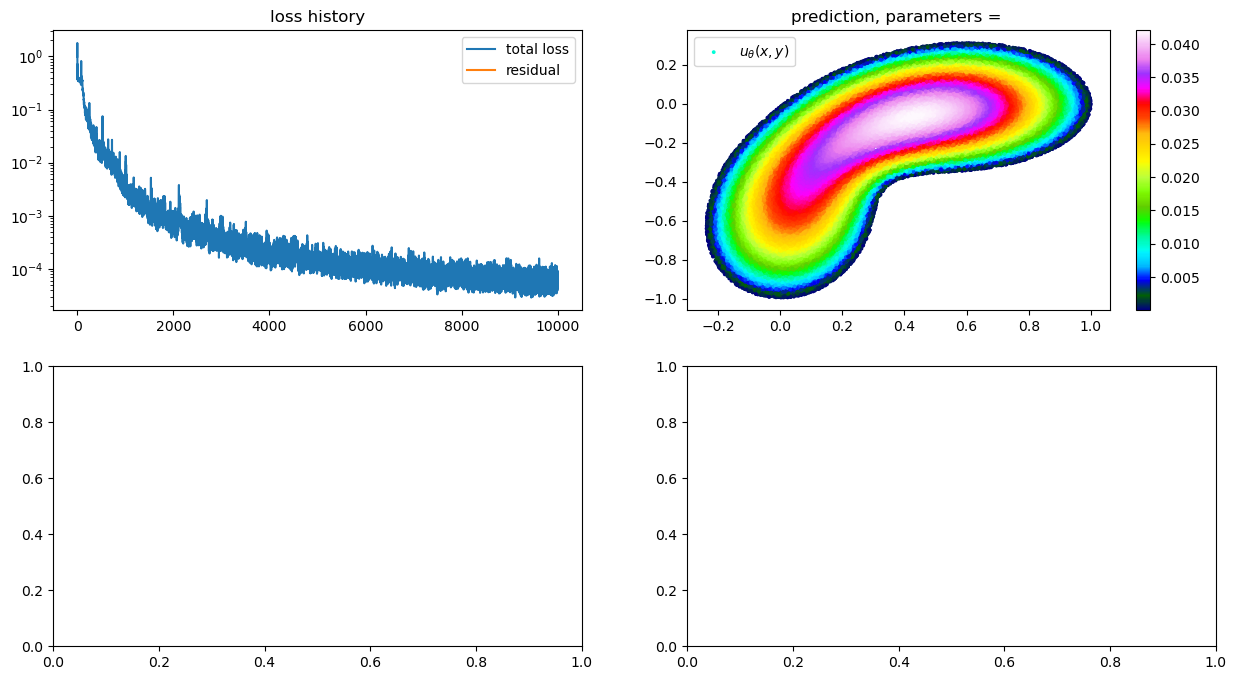

In [8]:
config_filename = models_dir+"config_"+str(config)+".json"
model_filename = models_dir+"model_"+str(config)+".pth"
print("### Config file : ",config_filename)
print("### Model file : ",model_filename)

dict = read_config(config_filename)
print("### Config ", config, " : ", dict)

trainer = run_Poisson2D(cas,config,dict)

## Dérivées

Compute derivatives :

In [9]:
def derivees_torch(u_pred,x,derive,direction):
    first_derivatives = grad_torch(u_pred["w"].sum(), x, create_graph=True)[0]
    du_dx = first_derivatives[:, 0]
    du_dy = first_derivatives[:, 1]
    if derive == 1:
        if direction == "x":
            return du_dx
        elif direction == "y":
            return du_dy
        else:
            ValueError("direction = 'x' or 'y'")
    elif derive == 2: 
        if direction == "x":
            second_derivatives_x = grad_torch(du_dx.sum(), x, create_graph=True)[0]
            return second_derivatives_x[:, 0]
        elif direction == "y":
            second_derivatives_y = grad_torch(du_dy.sum(), x, create_graph=True)[0]
            return second_derivatives_y[:, 1]
        else:
            ValueError("direction = 'x' or 'y'")
    else:
        ValueError("derive = 1 or 2")

In [10]:
if trainer.pde.nb_parameters == 0:
    params = [[None,None,None]]
else:
    mu = torch.mean(trainer.pde.parameter_domain, axis=1)
    S,f,p = mu.numpy()
    params = [[S,f,p]]

nb_vert = 32
deg_corr = 10

### Sur $\Omega$

Get the PINNs prediction :

In [12]:
solver = FEMSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get coordinates of the dof
parameter_domain = trainer.pde.parameter_domain
V_phi,X_test,mu_test = get_test_sample(solver,parameter_domain,deg_corr)
XXYY = X_test.x.detach().numpy()

# get u_PINNs
pred = trainer.network.setup_w_dict(X_test, mu_test)
phi_tild = pred["w"][:,0].cpu().detach().numpy()
u_PINNs = Function(V_phi)
u_PINNs.vector()[:] = phi_tild.copy()

hmin =  0.018247916933846434
hmax =  0.09123958466923217
mmg2d_O3 -nr -hmin 0.018247916933846434 -hmax 0.09123958466923217 -hausd 0.0018247916933846434 -ls -sol /tmp/tmpm7tz3uc7/Th.solb /tmp/tmpm7tz3uc7/Th.meshb


  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmpm7tz3uc7/Th.meshb OPENED
  %% /tmp/tmpm7tz3uc7/Th.solb OPENED
  -- DATA READING COMPLETED.     0.004s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   20000
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (7)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.002s

  -- PHASE 2 : ANALYSIS
  -- PHASE 2 COMPLETED.     0.000s

  -- PHASE 3 : MESH IMPROVEMENT
            4 splitted,     9778 collapsed,      687 swapped, 4 ite

discarding line.


  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmpa6mcwd1h/Th.meshb OPENED
  %% /tmp/tmpa6mcwd1h/Th.solb OPENED
  -- DATA READING COMPLETED.     0.004s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   20000
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (7)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.002s

  -- PHASE 2 : ANALYSIS
  -- PHASE 2 COMPLETED.     0.000s

  -- PHASE 3 : MESH IMPROVEMENT
            4 splitted,      325 collapsed,      246 swapped, 3 ite

discarding line.


  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmpwkmmqclk/Th.meshb OPENED
  %% /tmp/tmpwkmmqclk/Th.solb OPENED
  -- DATA READING COMPLETED.     0.004s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   20000
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (7)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.002s

  -- PHASE 2 : ANALYSIS
  -- PHASE 2 COMPLETED.     0.000s

  -- PHASE 3 : MESH IMPROVEMENT
            4 splitted,      172 collapsed,      289 swapped, 3 ite

discarding line.


Compute derivatives :

In [14]:
du_dx = derivees_torch(pred,X_test.x,1,"x")
du_dy = derivees_torch(pred,X_test.x,1,"y")

d2u_dx2 = derivees_torch(pred,X_test.x,2,"x")
d2u_dy2 = derivees_torch(pred,X_test.x,2,"y")

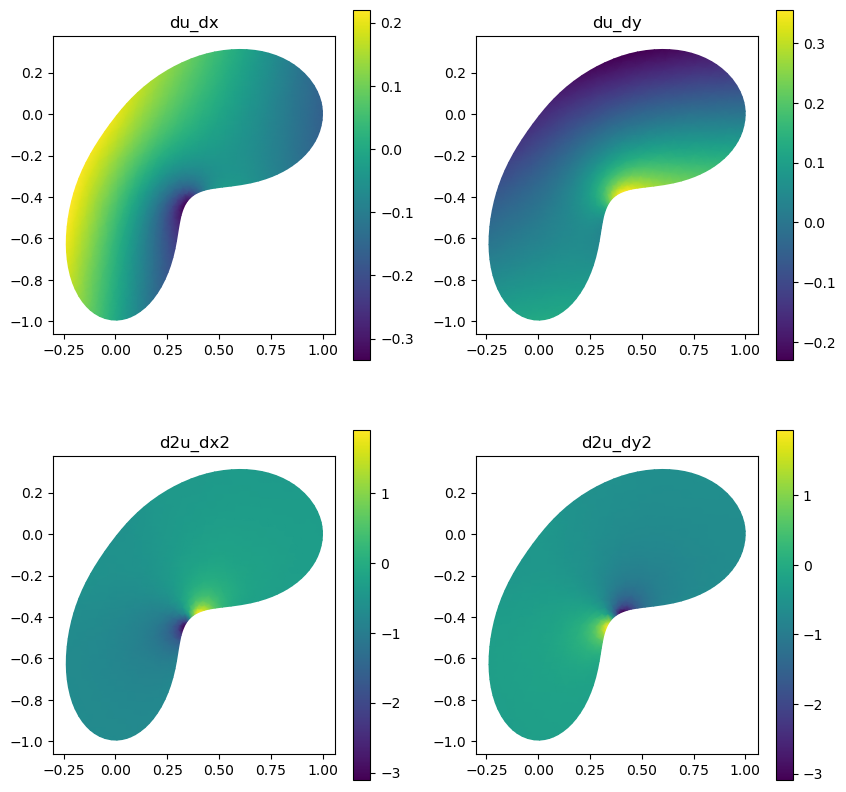

In [18]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
du_pytorch_FE = Function(V_phi)
du_pytorch_FE.vector()[:] = du_dx.detach().numpy().copy()
c = df.plot(du_pytorch_FE, mode="color",title="du_dx")
plt.colorbar(c)

plt.subplot(2,2,2)
du_pytorch_FE = Function(V_phi)
du_pytorch_FE.vector()[:] = du_dy.detach().numpy().copy()
c = df.plot(du_pytorch_FE, mode="color",title="du_dy")
plt.colorbar(c)

plt.subplot(2,2,3)
du_pytorch_FE = Function(V_phi)
du_pytorch_FE.vector()[:] = d2u_dx2.detach().numpy().copy()
c = df.plot(du_pytorch_FE, mode="color",title="d2u_dx2")
plt.colorbar(c)

plt.subplot(2,2,4)
du_pytorch_FE = Function(V_phi)
du_pytorch_FE.vector()[:] = d2u_dy2.detach().numpy().copy()
c = df.plot(du_pytorch_FE, mode="color",title="d2u_dy2")
plt.colorbar(c)


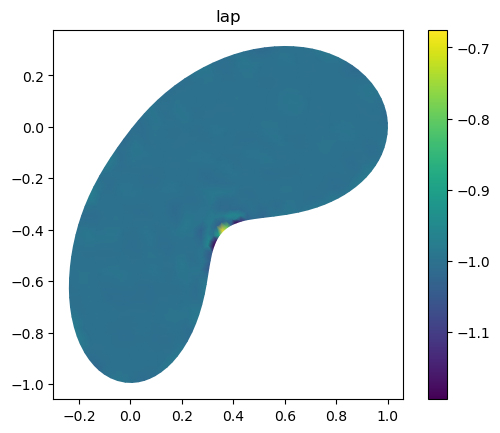

In [19]:
lap = d2u_dx2 + d2u_dy2
plt.figure()
du_pytorch_FE = Function(V_phi)
du_pytorch_FE.vector()[:] = lap.detach().numpy().copy()
c = df.plot(du_pytorch_FE, mode="color",title="lap")
plt.colorbar(c)

plt.show()